# Manage Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential


## Specify our model version

In [2]:
model_version = 'v7'

# Getting image data

In [3]:
import pathlib
import os

In [4]:
data_dir = 'data'

In [5]:
# # Remove invalid format images
# import cv2
# import imghdr
# data_dir = 'data' 
# image_exts = ['jpeg','jpg', 'bmp', 'png']
# # remove images with invalid file formats
# for image_class in os.listdir(data_dir):
#     for image in os.listdir(os.path.join(data_dir,image_class)):
#         image_path = os.path.join(data_dir, image_class, image)
#         try:
#             img = cv2.imread(image_path)
#             tip = imghdr.what(image_path)
#             if tip not in image_exts:
#                 print("Image not in ext list {}".format(image_path))
#                 os.remove(image_path)
#         except Exception as e:
#             print('Issue with image {}'.format(image_path))
#             #os.remove(image_path)

# Defining model parameters

In [6]:
batch_size = 32
img_height = 180
img_width = 180

# Defining training and validation split
Model v3 has a Train-Validate-Test ration of 80-10-10

In [7]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 12394 files belonging to 3 classes.
Using 9916 files for training.
Found 12394 files belonging to 3 classes.
Using 2478 files for validation.


In [8]:
print("Validate and test batches: " + str(val_ds.cardinality().numpy()) + "\n")
# Calculate the split point (assuming even split for simplicity)
split_point = val_ds.cardinality().numpy() // 2

# Create test_ds by taking the first half
test_ds = val_ds.take(split_point)

# Create val_ds by skipping the first half
val_ds = val_ds.skip(split_point)

print("Training batches: " + str(train_ds.cardinality().numpy()))
print("Validate batches: " + str(val_ds.cardinality().numpy()))
print("Test batches: " + str(test_ds.cardinality().numpy()))

Validate and test batches: 78

Training batches: 310
Validate batches: 39
Test batches: 39


### Analyse the class names

In [9]:
class_names = train_ds.class_names
print(class_names)

['banana', 'lemon', 'unknown']


## Visualise our images

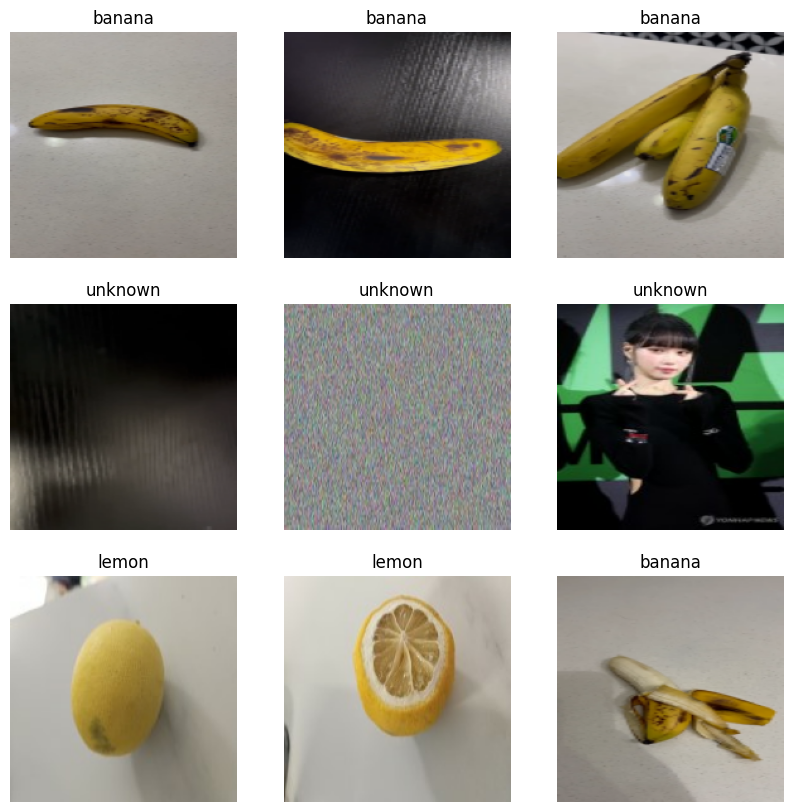

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")


### Configure the dataset for performance

In [11]:
'''

Dataset.cache keeps the images in memory after they're loaded off disk during the first epoch. 
This will ensure the dataset does not become a bottleneck while training your model. 
If your dataset is too large to fit into memory, you can also use this method to create a performant on-disk cache.

Dataset.prefetch overlaps data preprocessing and model execution while training.

'''

AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)


### Standardize the data
THe RGB values are in the range of 0-255, which is not ideal for ML.
Therefore we will standardize them to [0,1]

THe line of code below is just to demonstrate the use of layers.Rescaling. Our model will already include this layer within it's architecture (see subsequent lines)

In [12]:
normalization_layer = layers.Rescaling(1./255)


## Rotating images instances to assist with overfitting problems

In [13]:
# data augmentation to reduce overfitting
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)


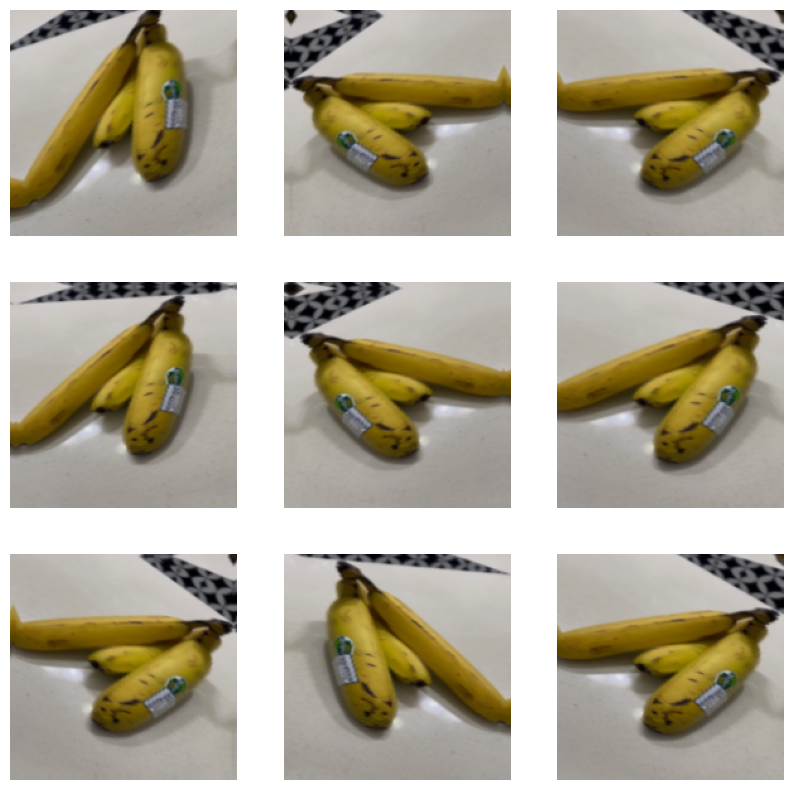

In [14]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")


# Building the Model

In [15]:
# creating model
# re-scalling is done within the model building process already

num_classes = len(class_names)

# Applying Dropout to the model
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='leaky_relu'),
  layers.Dense(num_classes, name="outputs")
])



## Compilise the model
For model v1, we are using the adam optimizer, as well as the SparseCategoricalCrossentropy loss function to plot the model's performance.

In [16]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])



### Summarize the model

In [17]:
model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 180, 180, 3)       0         
                                                                 
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 90, 90, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 45, 45, 32)        0         
 g2D)                                                 

## Train the model
For model v1, we decided with 15 epochs

In [18]:
epochs = 15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)


Epoch 1/15


310/310 [==============================] - 46s 144ms/step - loss: 0.2938 - accuracy: 0.8942 - val_loss: 0.1491 - val_accuracy: 0.9374
Epoch 2/15
310/310 [==============================] - 42s 136ms/step - loss: 0.1050 - accuracy: 0.9685 - val_loss: 0.0332 - val_accuracy: 0.9935
Epoch 3/15
310/310 [==============================] - 42s 136ms/step - loss: 0.0730 - accuracy: 0.9785 - val_loss: 0.0549 - val_accuracy: 0.9837
Epoch 4/15
310/310 [==============================] - 41s 131ms/step - loss: 0.0512 - accuracy: 0.9878 - val_loss: 0.0750 - val_accuracy: 0.9797
Epoch 5/15
310/310 [==============================] - 41s 132ms/step - loss: 0.0494 - accuracy: 0.9862 - val_loss: 0.0284 - val_accuracy: 0.9951
Epoch 6/15
310/310 [==============================] - 41s 132ms/step - loss: 0.0331 - accuracy: 0.9883 - val_loss: 0.0217 - val_accuracy: 0.9951
Epoch 7/15
310/310 [==============================] - 43s 138ms/step - loss: 0.0367 - accuracy: 0.9889 - val_loss: 0.0477 - val_

## Visualise training results

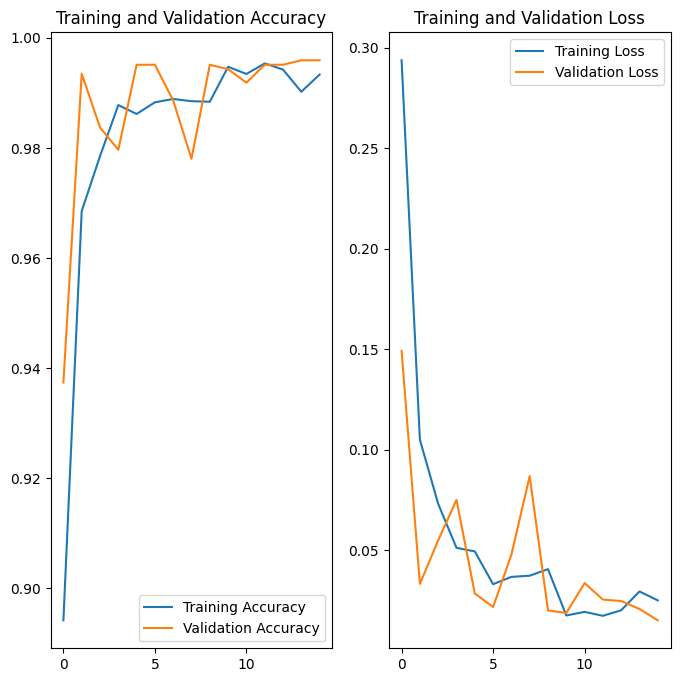

In [19]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# Saving the model 
## (IMPORTANT: RENAME THE VERSION TO THE ONE I'M WORKING ON)

In [20]:
# Save the entire model to a HDF5 file.
# The '.h5' extension indicates that the model should be saved to HDF5.
model.save('./models/my_model_' + model_version + '.h5')


C:\Users\Ryan Chan\AppData\Roaming\Python\Python311\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# Predicting on new data

## Predicting with the test batch

In [21]:
# Evaluate the model on the test dataset
evaluation_result = model.evaluate(test_ds)

# Retrieve metric names
metric_names = model.metrics_names

# Print the evaluation result with metric names
for name, result in zip(metric_names, evaluation_result):
    print(f"{name}: {result}")

39/39 [==============================] - 1s 31ms/step - loss: 0.0223 - accuracy: 0.9968
loss: 0.022286701947450638
accuracy: 0.9967948794364929


## Predicting an image on the internet

import sys  # Import the sys module to access system-specific parameters and functions

# Print the Python version to the console
print("Python version")

# Use the sys.version attribute to get the Python version and print it
print(sys.version)

# Print information about the Python version
print("Version info.")

# Use the sys.version_info attribute to get detailed version information and print it
print(sys.version_info)

# this works! Tha means if we manage to livestream our camera to a specific url, then put the url in here,
# we should get a live response for what we classify it as.

test_url = input("enter url: ")
test_path = tf.keras.utils.get_file(origin=test_url)

img = tf.keras.utils.load_img(
    test_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)
